# Sistem AI: CNN ResNet untuk Klasifikasi Tahap Fermentasi Kakao (Computer Vision)

## Tujuan

**Rancangan AI ini menjadi komponen kunci dalam analisis prediktif dan pendukung keputusan untuk mencegah kegagalan fermentasi.**

Sistem ini mengimplementasikan **CNN dengan ResNet** untuk:
- **Klasifikasi Tahap Fermentasi**: Mengklasifikasikan biji kakao ke dalam kategori tahap fermentasi berdasarkan citra visual
- **Ekstraksi Fitur Otomatis**: CNN secara otomatis mengekstrak fitur warna dan tekstur dari citra
- **Transfer Learning**: Menggunakan ResNet50 yang telah dilatih pada ImageNet untuk performa yang lebih baik

## Kategori Klasifikasi

Model akan mengklasifikasikan biji kakao ke dalam kategori:
- **"Optimal"** (Fermentasi Optimal) - Proses fermentasi berjalan dengan baik
- **"Gagal: Under-Fermented"** (Belum Fermentasi) - Proses fermentasi belum cukup
- **"Gagal: Over-Fermented"** (Fermentasi Berlebih) - Proses fermentasi berlebihan


In [1]:
# Import Library yang Diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from skimage.feature import graycomatrix, graycoprops
from skimage import color, measure
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras untuk CNN
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    TENSORFLOW_AVAILABLE = True
    print("TensorFlow tersedia untuk CNN ResNet")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow tidak tersedia. Silakan install dengan: pip install tensorflow")

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Library berhasil diimport!")


TensorFlow tersedia untuk CNN ResNet
Library berhasil diimport!


## 1. Pengumpulan dan Pra-pemrosesan Data Citra

### a) Akuisisi Citra
- Gambar biji kakao diambil secara berkala (100 gambar/hari)
- Pencahayaan konsisten untuk meminimalkan noise dan bayangan

### b) Pra-pemrosesan dengan OpenCV
- **Resizing & Normalisasi**: Menyesuaikan dimensi ke 224x224 piksel
- **Segmentasi**: Memisahkan objek biji kakao dari latar belakang menggunakan thresholding
- **Ekstraksi Fitur Warna**: RGB, HSV, Lab (Hue, Saturation, Value)
- **Ekstraksi Fitur Tekstur**: GLCM (contrast, homogeneity, energy, correlation)
- **Ekstraksi Fitur Morfologi**: Area, perimeter, compactness, aspect ratio


In [2]:
# Fungsi untuk Pra-pemrosesan Citra
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Pra-pemrosesan citra: Resizing & Normalisasi ke 224x224
    
    Parameters:
    -----------
    image_path : str
        Path ke file gambar
    target_size : tuple
        Ukuran target (default: 224x224 untuk ResNet)
    
    Returns:
    --------
    processed_image : numpy array
        Citra yang sudah diproses (224x224, RGB)
    """
    # Baca gambar
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Tidak dapat membaca gambar: {image_path}")
    
    # Konversi BGR ke RGB (OpenCV membaca sebagai BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize ke target size
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    
    # Normalisasi nilai piksel ke [0, 1]
    img_normalized = img_resized.astype(np.float32) / 255.0
    
    return img_normalized

# Fungsi untuk Segmentasi (Thresholding di HSV color space)
def segment_cocoa_bean(image):
    """
    Segmentasi: Memisahkan objek biji kakao dari latar belakang
    menggunakan thresholding di HSV color space
    
    Parameters:
    -----------
    image : numpy array
        Citra RGB yang sudah dinormalisasi [0, 1]
    
    Returns:
    --------
    mask : numpy array
        Mask biner untuk biji kakao
    segmented_image : numpy array
        Citra yang sudah di-segmentasi
    """
    # Konversi ke HSV
    img_uint8 = (image * 255).astype(np.uint8)
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    
    # Threshold untuk warna cokelat/biji kakao
    # Range warna cokelat di HSV
    lower_brown = np.array([10, 50, 50])
    upper_brown = np.array([30, 255, 255])
    
    # Buat mask
    mask = cv2.inRange(hsv, lower_brown, upper_brown)
    
    # Aplikasikan mask ke citra
    segmented_image = cv2.bitwise_and(img_uint8, img_uint8, mask=mask)
    
    return mask, segmented_image

print("Fungsi pra-pemrosesan citra siap digunakan!")


Fungsi pra-pemrosesan citra siap digunakan!


In [3]:
# Fungsi untuk Ekstraksi Fitur Warna (RGB, HSV, Lab)
def extract_color_features(image, mask=None):
    """
    Ekstraksi fitur warna dari citra pada berbagai ruang warna
    
    Parameters:
    -----------
    image : numpy array
        Citra RGB [0, 1]
    mask : numpy array (optional)
        Mask untuk area yang akan dianalisis
    
    Returns:
    --------
    color_features : dict
        Dictionary berisi fitur warna
    """
    img_uint8 = (image * 255).astype(np.uint8)
    
    # Jika ada mask, gunakan untuk memfilter area
    if mask is not None:
        img_uint8 = cv2.bitwise_and(img_uint8, img_uint8, mask=mask)
    
    # RGB features
    r_mean = np.mean(img_uint8[:, :, 0])
    g_mean = np.mean(img_uint8[:, :, 1])
    b_mean = np.mean(img_uint8[:, :, 2])
    
    # HSV features
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    h_mean = np.mean(hsv[:, :, 0])  # Hue
    s_mean = np.mean(hsv[:, :, 1])  # Saturation
    v_mean = np.mean(hsv[:, :, 2])  # Value
    
    # Lab features
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    l_mean = np.mean(lab[:, :, 0])  # Lightness
    a_mean = np.mean(lab[:, :, 1])  # Green-Red
    b_lab_mean = np.mean(lab[:, :, 2])  # Blue-Yellow
    
    return {
        'rgb_r': r_mean,
        'rgb_g': g_mean,
        'rgb_b': b_mean,
        'hsv_h': h_mean,
        'hsv_s': s_mean,
        'hsv_v': v_mean,
        'lab_l': l_mean,
        'lab_a': a_mean,
        'lab_b': b_lab_mean
    }

# Fungsi untuk Ekstraksi Fitur Tekstur (GLCM)
def extract_texture_features(image, mask=None):
    """
    Ekstraksi fitur tekstur menggunakan GLCM (Grey-Level Co-occurrence Matrix)
    
    Parameters:
    -----------
    image : numpy array
        Citra RGB [0, 1]
    mask : numpy array (optional)
        Mask untuk area yang akan dianalisis
    
    Returns:
    --------
    texture_features : dict
        Dictionary berisi fitur tekstur (contrast, homogeneity, energy, correlation)
    """
    # Konversi ke grayscale
    img_uint8 = (image * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
    
    # Jika ada mask, aplikasikan
    if mask is not None:
        gray = cv2.bitwise_and(gray, gray, mask=mask)
    
    # Hitung GLCM
    # distances dan angles untuk GLCM
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    try:
        glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
        
        # Ekstrak properti GLCM
        contrast = graycoprops(glcm, 'contrast').mean()
        homogeneity = graycoprops(glcm, 'homogeneity').mean()
        energy = graycoprops(glcm, 'energy').mean()
        correlation = graycoprops(glcm, 'correlation').mean()
    except:
        # Fallback jika GLCM gagal
        contrast = homogeneity = energy = correlation = 0.0
    
    return {
        'texture_contrast': contrast,
        'texture_homogeneity': homogeneity,
        'texture_energy': energy,
        'texture_correlation': correlation
    }

# Fungsi untuk Ekstraksi Fitur Morfologi
def extract_morphological_features(mask):
    """
    Ekstraksi fitur morfologi (bentuk dan ukuran)
    
    Parameters:
    -----------
    mask : numpy array
        Mask biner
    
    Returns:
    --------
    morph_features : dict
        Dictionary berisi fitur morfologi
    """
    if mask is None or np.sum(mask) == 0:
        return {
            'area': 0,
            'perimeter': 0,
            'compactness': 0,
            'aspect_ratio': 0
        }
    
    # Temukan kontur
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return {
            'area': 0,
            'perimeter': 0,
            'compactness': 0,
            'aspect_ratio': 0
        }
    
    # Ambil kontur terbesar
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Area
    area = cv2.contourArea(largest_contour)
    
    # Perimeter
    perimeter = cv2.arcLength(largest_contour, True)
    
    # Compactness (4π * area / perimeter²)
    compactness = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    
    # Aspect ratio (width / height dari bounding box)
    x, y, w, h = cv2.boundingRect(largest_contour)
    aspect_ratio = w / h if h > 0 else 0
    
    return {
        'area': area,
        'perimeter': perimeter,
        'compactness': compactness,
        'aspect_ratio': aspect_ratio
    }

print("Fungsi ekstraksi fitur siap digunakan!")


Fungsi ekstraksi fitur siap digunakan!


## 2. Loading Data Citra dari Folder

Data citra biji kakao berada di folder `data/`. Kita akan:
1. Membaca semua gambar dari folder
2. Melakukan pra-pemrosesan
3. Membuat label (untuk demo, kita akan membuat label berdasarkan metadata atau struktur)


Menemukan 520 file gambar di folder data/
   Contoh file: [PosixPath('data/DSCF2208.JPG'), PosixPath('data/DSCF2234.JPG'), PosixPath('data/DSCF2552.JPG'), PosixPath('data/DSCF2546.JPG'), PosixPath('data/DSCF2220.JPG')]

Distribusi Label (Demo):
   Gagal: Over-Fermented: 307 gambar (59.0%)
   Optimal: 154 gambar (29.6%)
   Gagal: Under-Fermented: 59 gambar (11.3%)


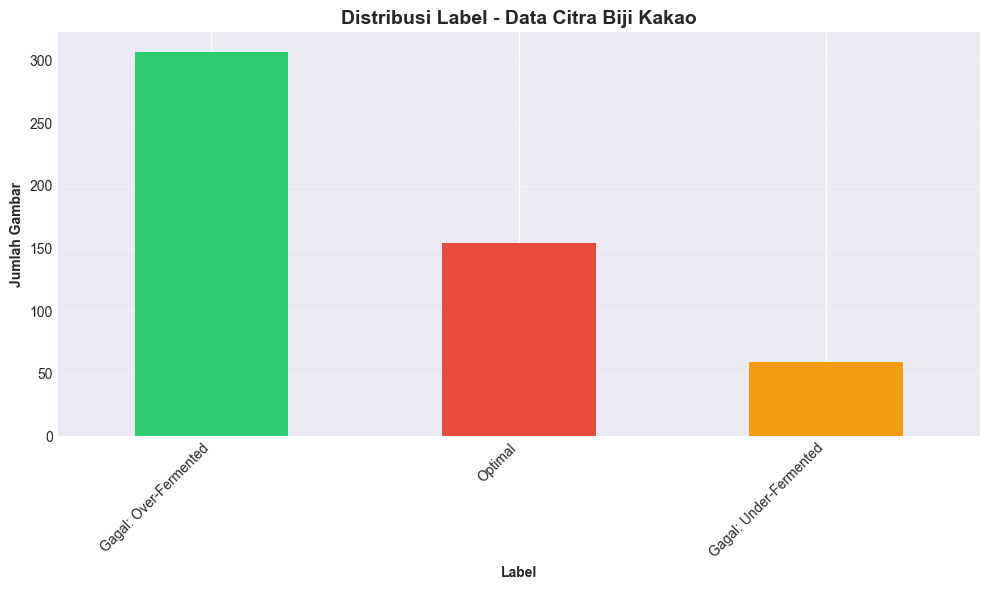

In [4]:
# Loading Data Citra dari Folder
data_dir = Path("data")
image_files = list(data_dir.glob("*.JPG")) + list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.png"))

print(f"Menemukan {len(image_files)} file gambar di folder data/")
print(f"   Contoh file: {image_files[:5] if len(image_files) > 0 else 'Tidak ada file'}")

# Untuk demo, kita akan membuat label berdasarkan nama file atau metadata
# Dalam implementasi nyata, label akan berasal dari data historis
# Kita akan membuat sistem label sederhana berdasarkan nomor file (untuk simulasi)

def create_labels_from_files(image_files):
    """
    Membuat label dari file (untuk demo)
    Dalam implementasi nyata, label akan berasal dari data historis
    """
    labels = []
    for img_file in image_files:
        # Ekstrak nomor dari nama file (misalnya DSCF2138.JPG -> 2138)
        try:
            file_num = int(''.join(filter(str.isdigit, img_file.stem)))
            # Simulasi: bagi menjadi 3 kategori berdasarkan nomor
            # Ini hanya untuk demo - dalam implementasi nyata, gunakan label aktual
            if file_num < 2200:
                labels.append("Gagal: Under-Fermented")
            elif file_num < 2500:
                labels.append("Optimal")
            else:
                labels.append("Gagal: Over-Fermented")
        except:
            # Default ke Optimal jika tidak bisa parse
            labels.append("Optimal")
    return labels

# Buat label (untuk demo)
if len(image_files) > 0:
    labels = create_labels_from_files(image_files)
    print(f"\nDistribusi Label (Demo):")
    label_counts = pd.Series(labels).value_counts()
    for label, count in label_counts.items():
        print(f"   {label}: {count} gambar ({count/len(labels)*100:.1f}%)")
    
    # Visualisasi distribusi label
    plt.figure(figsize=(10, 6))
    label_counts.plot(kind='bar', color=['#2ecc71', '#e74c3c', '#f39c12'])
    plt.title('Distribusi Label - Data Citra Biji Kakao', fontsize=14, fontweight='bold')
    plt.xlabel('Label', fontweight='bold')
    plt.ylabel('Jumlah Gambar', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada file gambar ditemukan di folder data/")
    labels = []


## 2.1. Preview Tahap Pemrosesan Citra

Berikut adalah preview visualisasi untuk setiap tahap pemrosesan citra pada beberapa contoh gambar:


PREVIEW TAHAP PEMROSESAN CITRA

Menampilkan preview untuk 5 contoh gambar...



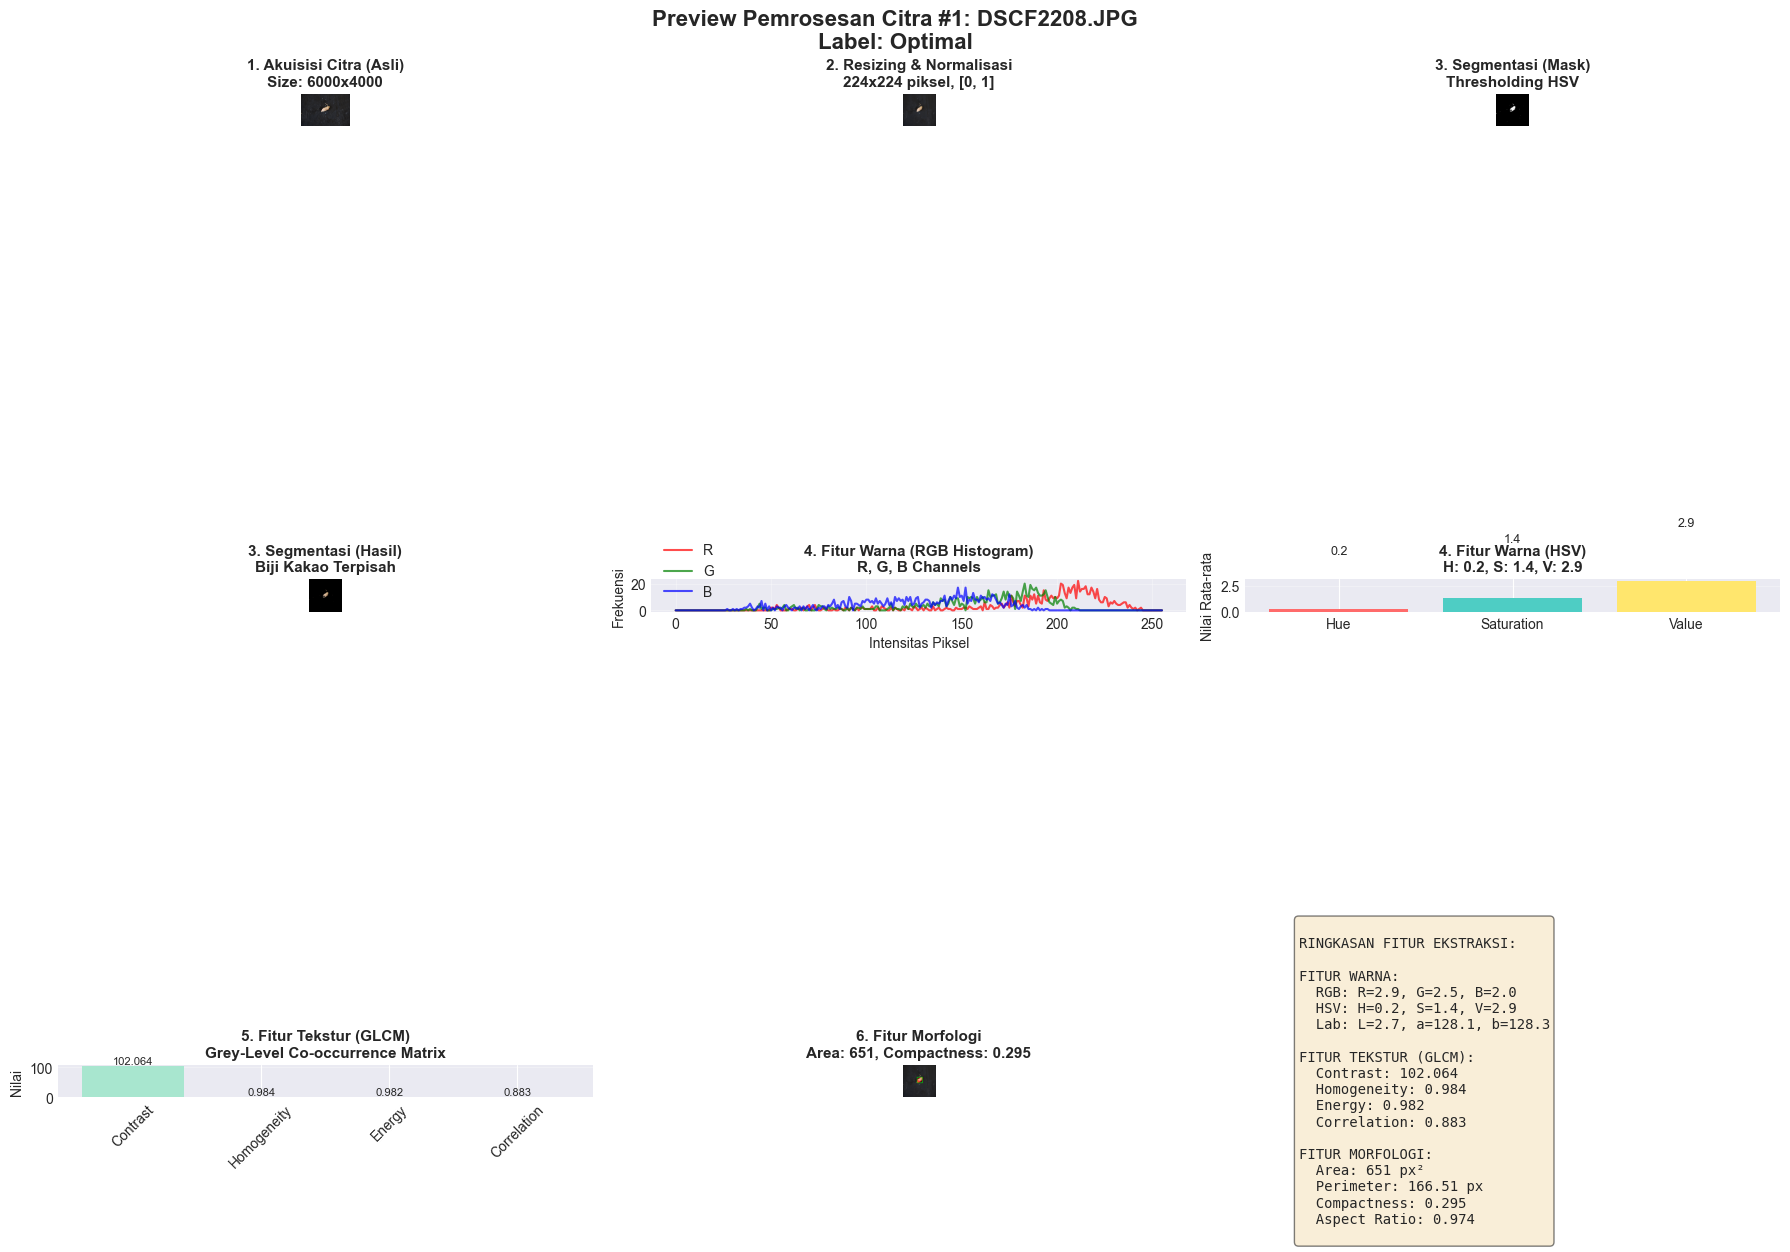

Preview #1 selesai: DSCF2208.JPG


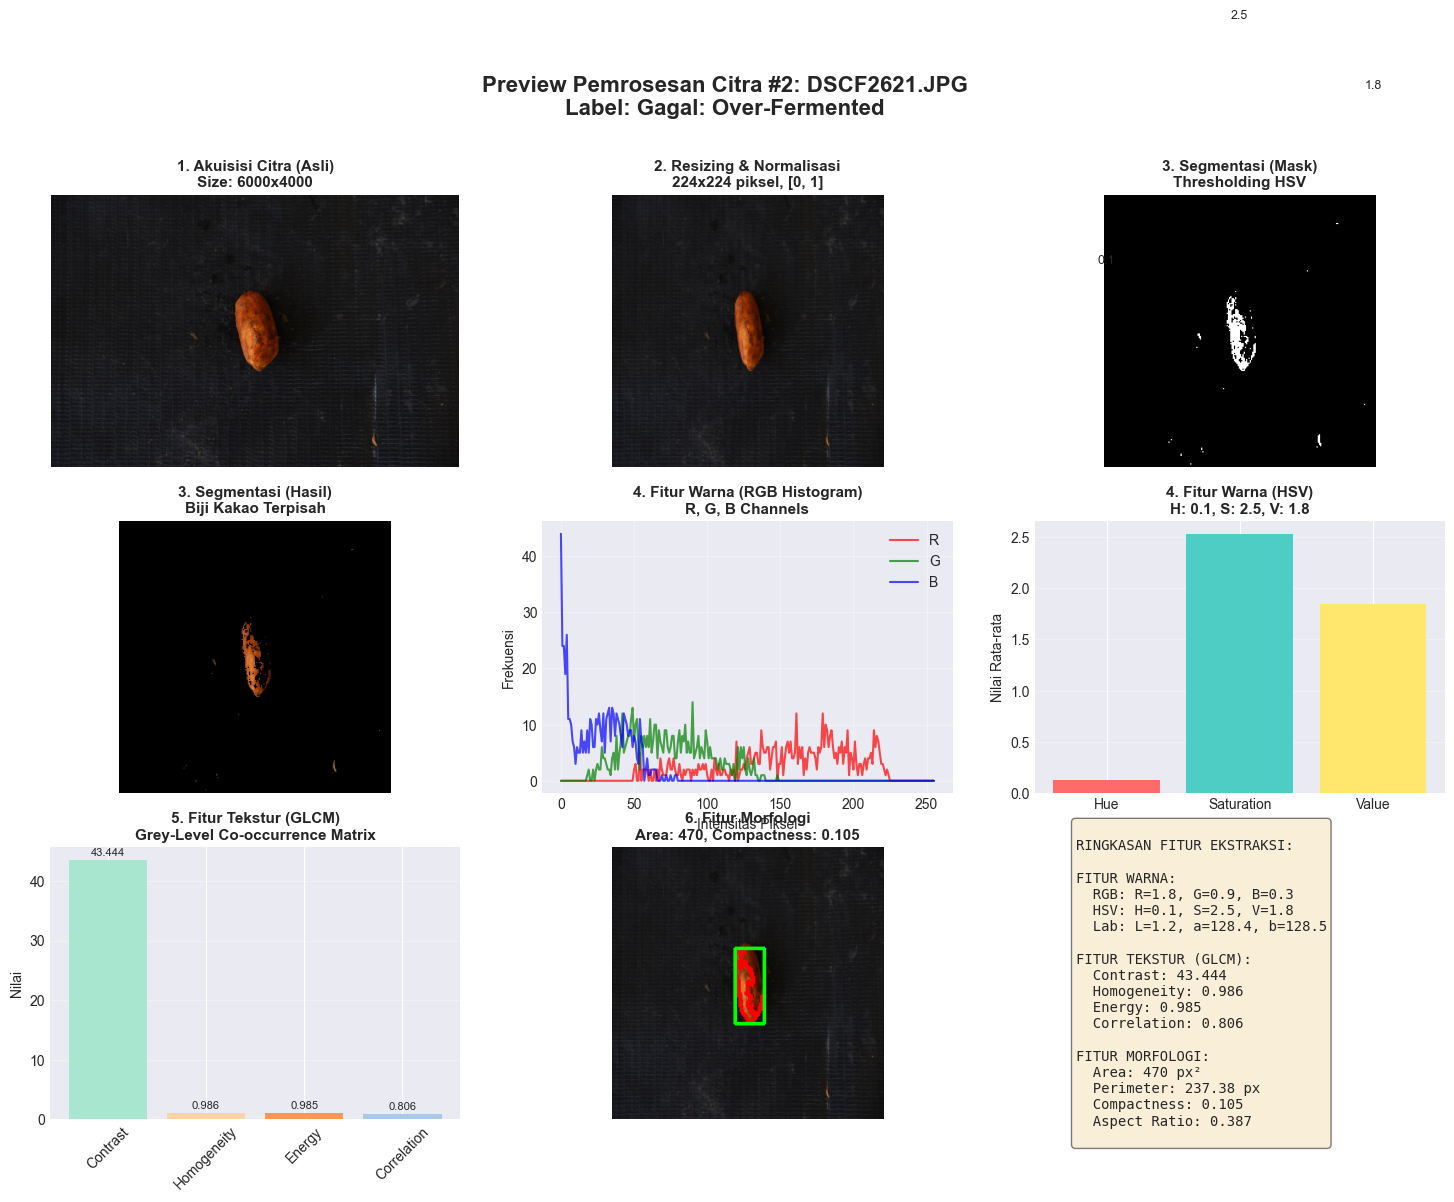

Preview #2 selesai: DSCF2621.JPG


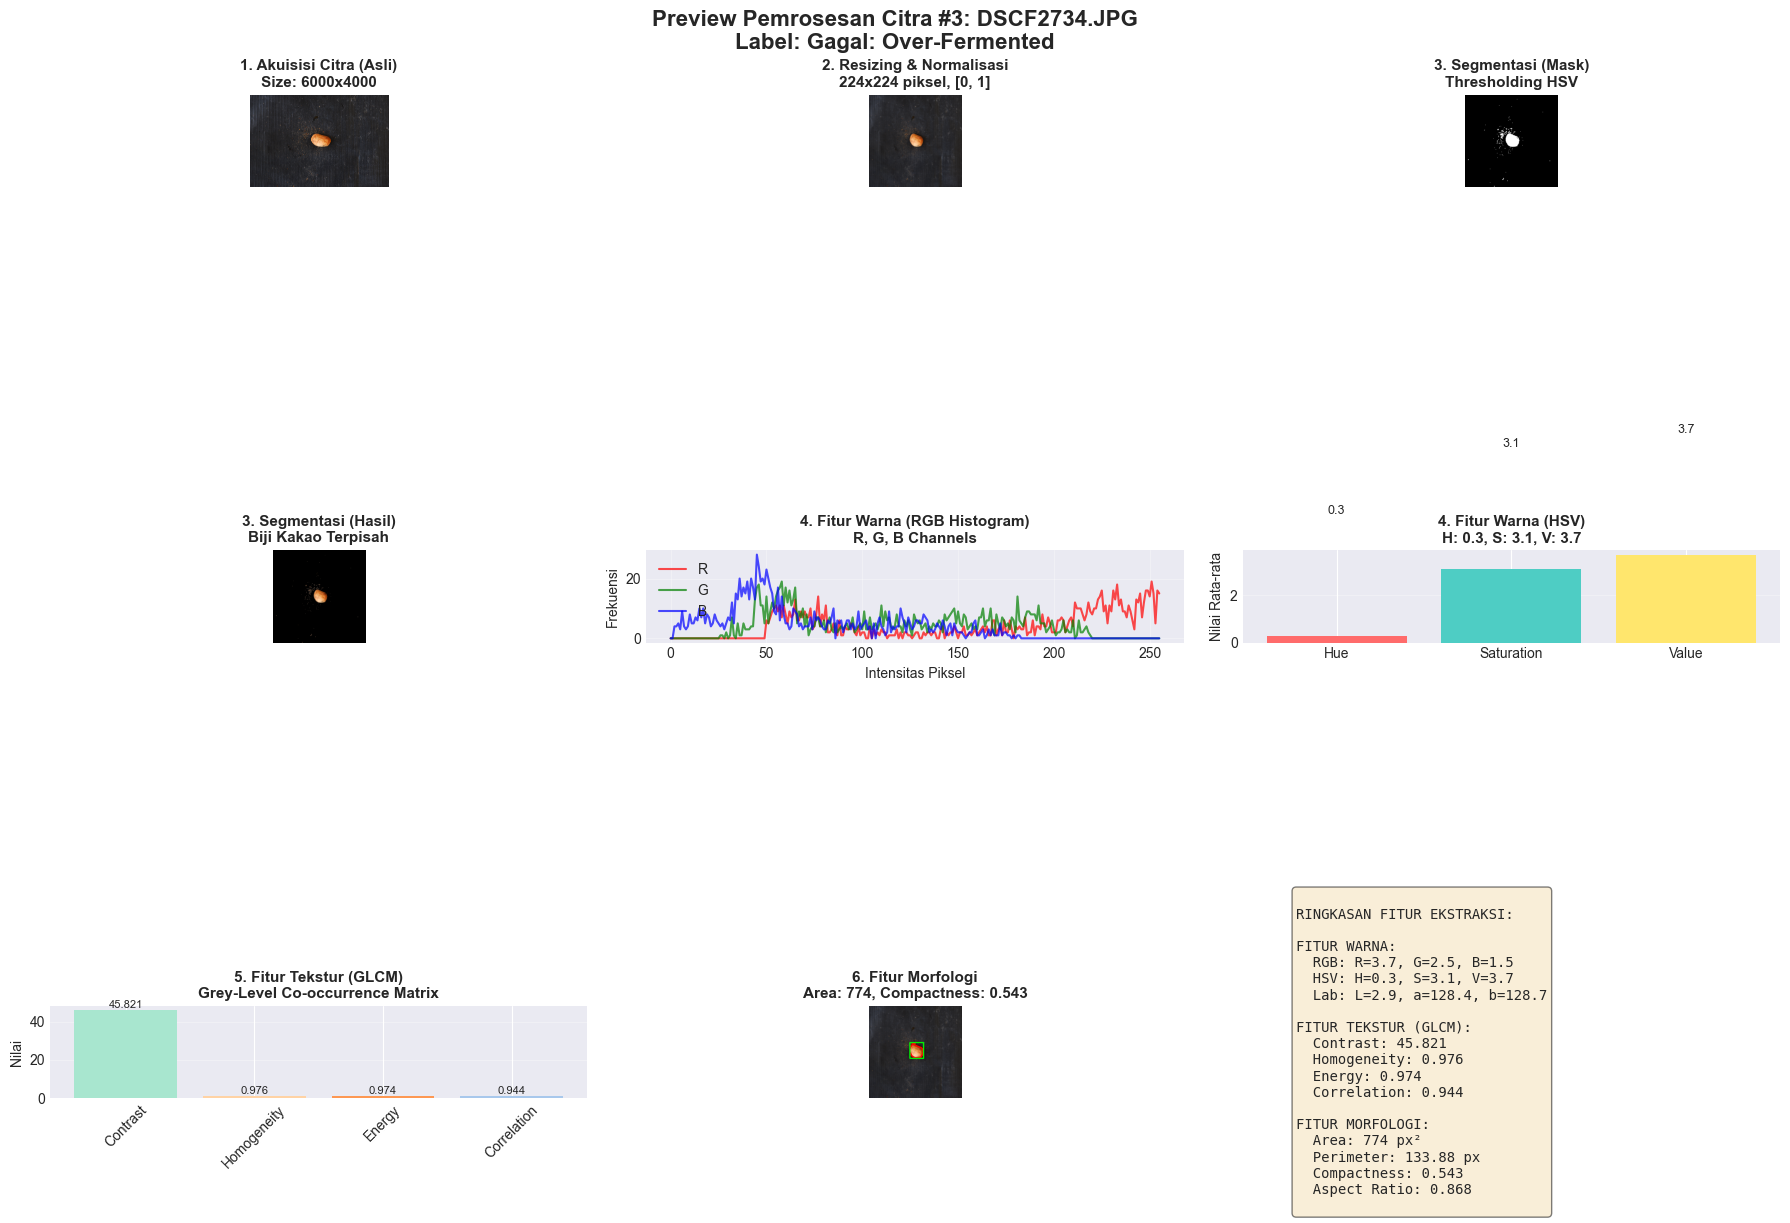

Preview #3 selesai: DSCF2734.JPG


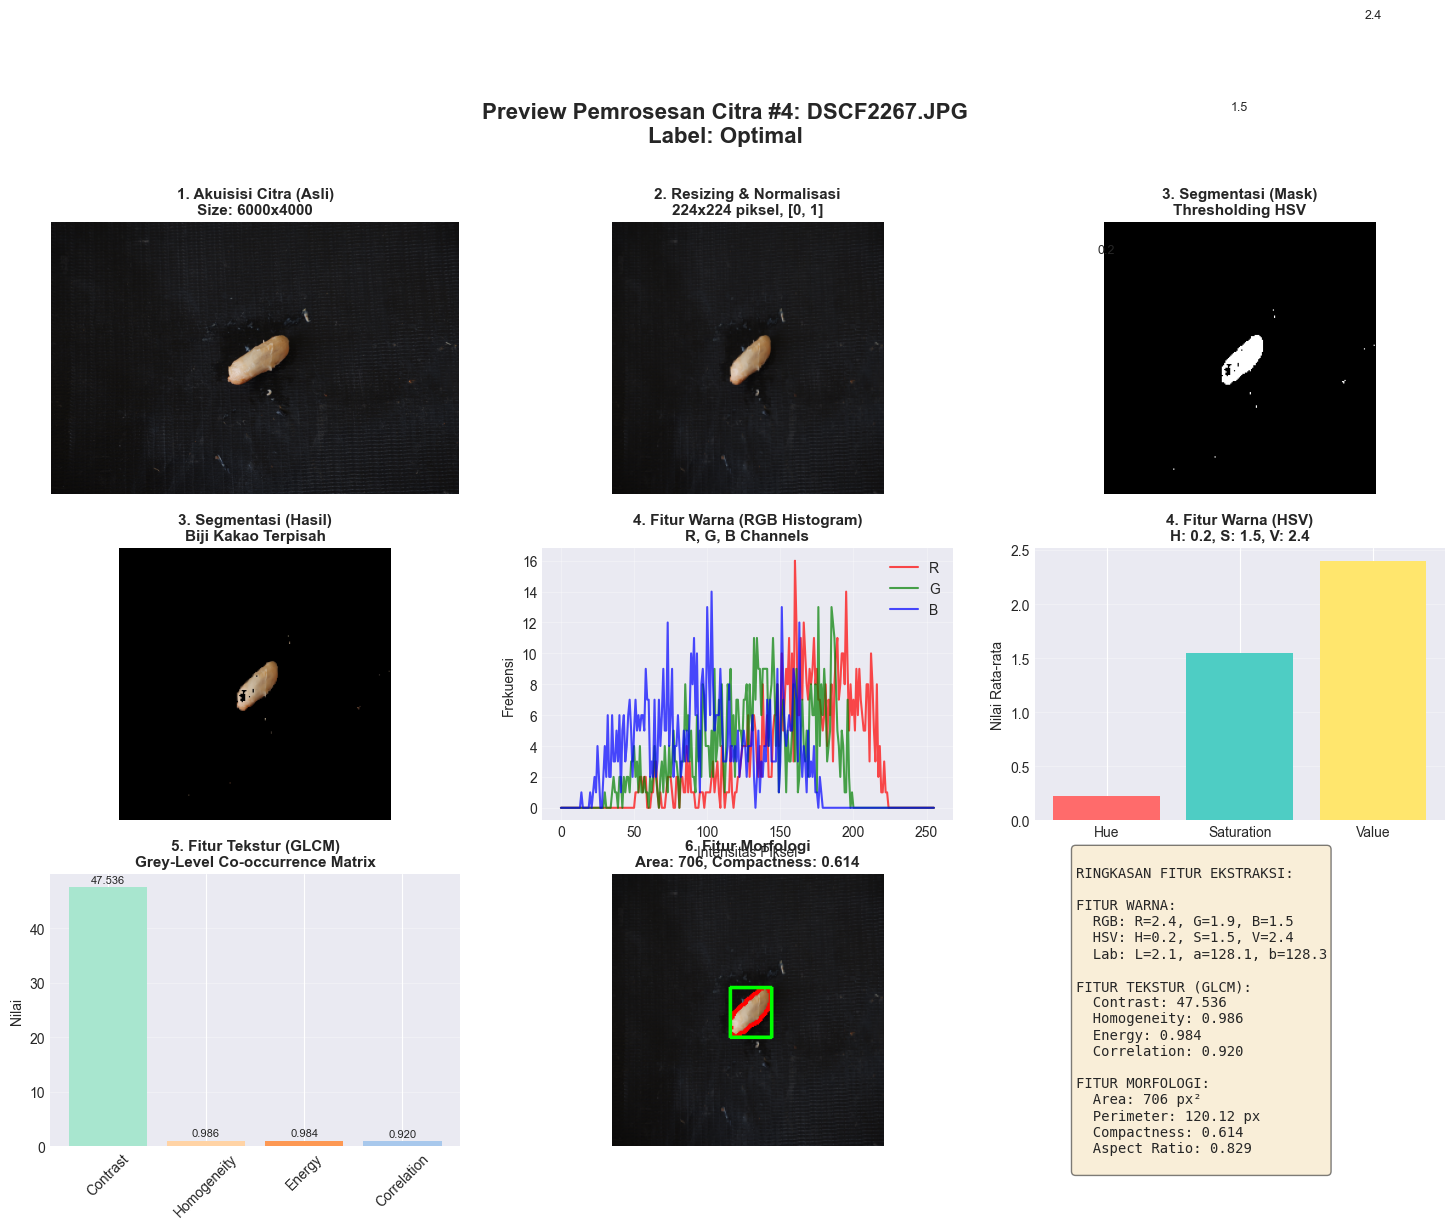

Preview #4 selesai: DSCF2267.JPG


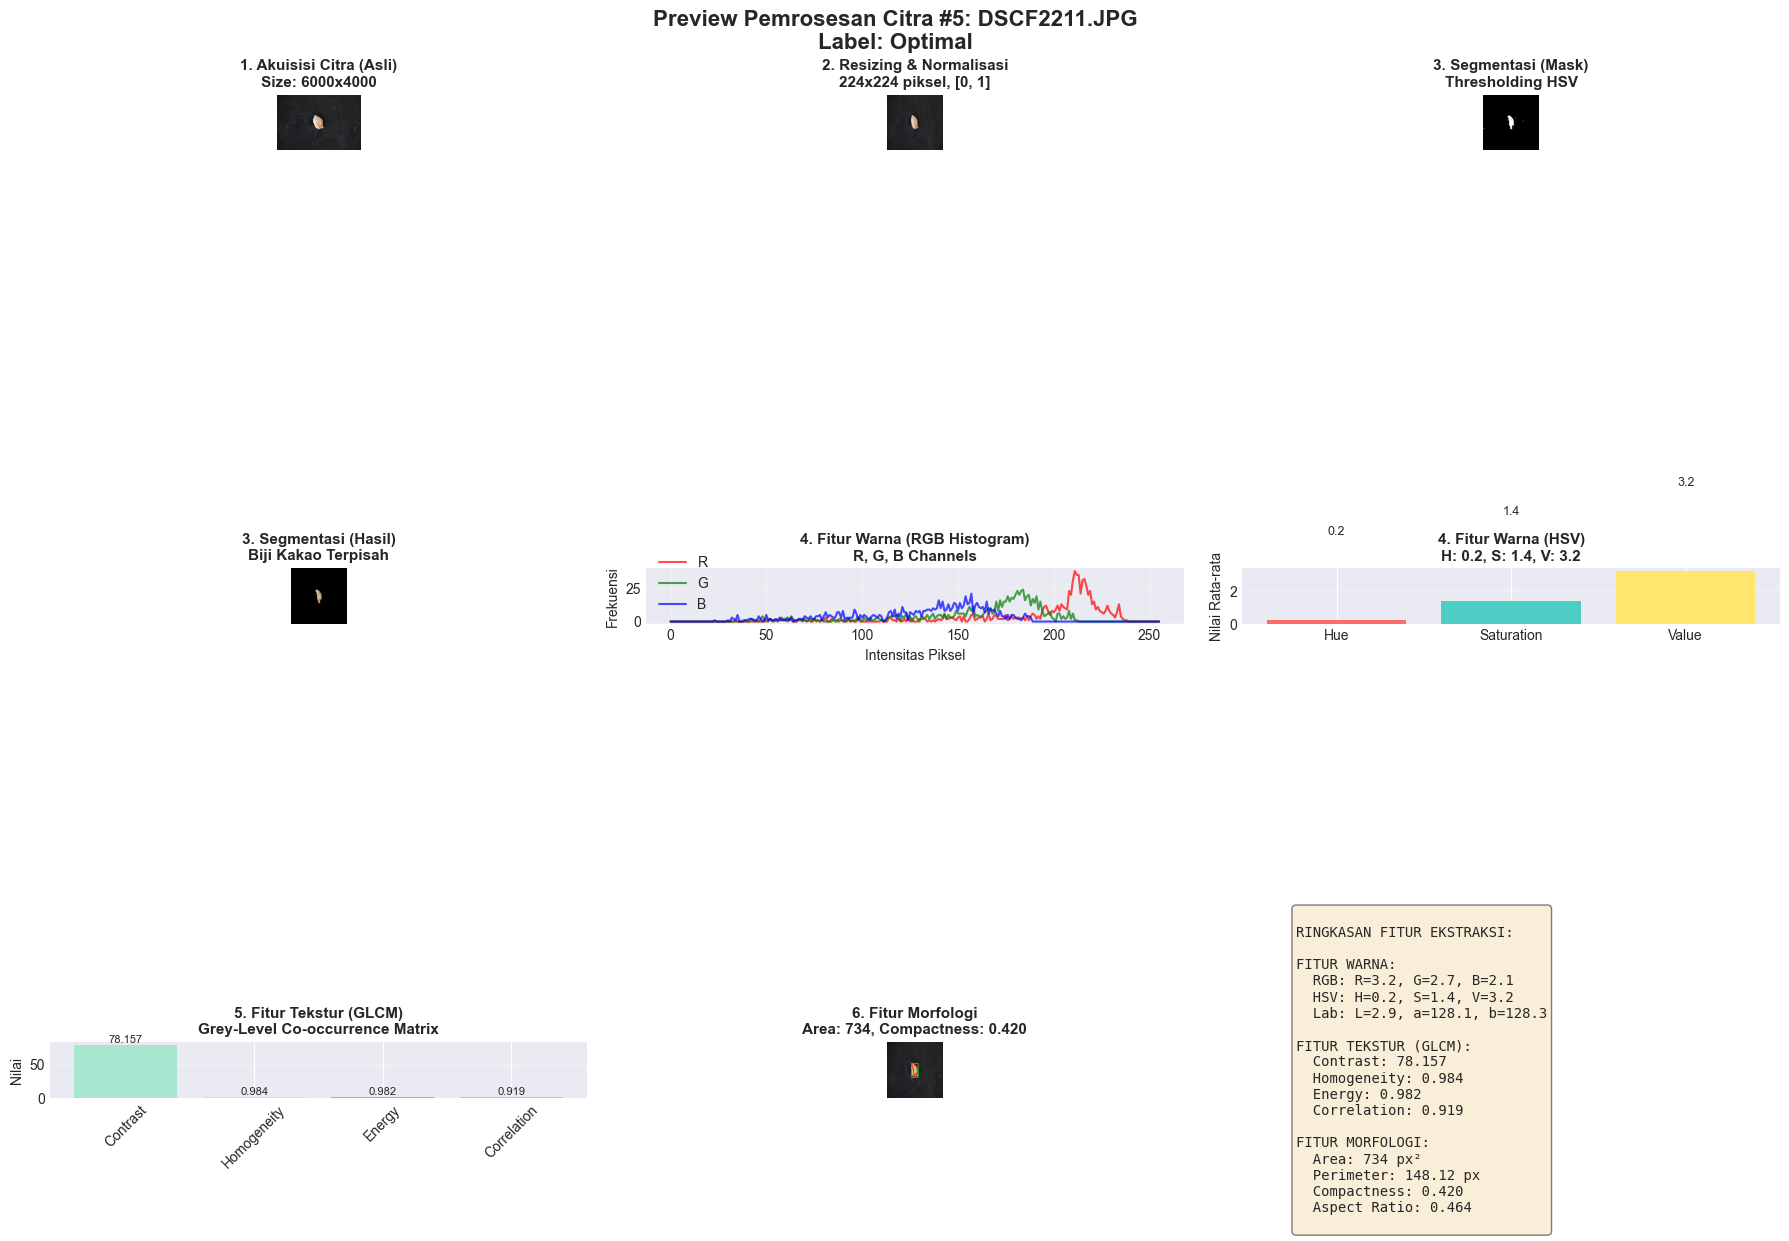

Preview #5 selesai: DSCF2211.JPG

Preview pemrosesan citra selesai untuk 5 contoh gambar


In [5]:
# Preview Tahap Pemrosesan Citra - Visualisasi untuk Beberapa Contoh Gambar
if len(image_files) > 0:
    # Ambil beberapa contoh gambar untuk ditampilkan (3-5 gambar)
    num_examples = min(5, len(image_files))
    example_indices = np.linspace(0, len(image_files)-1, num_examples, dtype=int)
    
    print("="*70)
    print("PREVIEW TAHAP PEMROSESAN CITRA")
    print("="*70)
    print(f"\nMenampilkan preview untuk {num_examples} contoh gambar...\n")
    
    for idx, example_idx in enumerate(example_indices):
        img_file = image_files[example_idx]
        label = labels[example_idx]
        
        try:
            # 1. Akuisisi Citra: Gambar Asli
            img_original = cv2.imread(str(img_file))
            img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
            original_height, original_width = img_original_rgb.shape[:2]
            
            # 2. Resizing & Normalisasi
            img_resized = preprocess_image(img_file, target_size=(224, 224))
            img_resized_display = (img_resized * 255).astype(np.uint8)
            
            # 3. Segmentasi
            mask, segmented_img = segment_cocoa_bean(img_resized)
            
            # 4. Ekstraksi Fitur Warna
            color_features = extract_color_features(img_resized, mask=mask)
            
            # 5. Ekstraksi Fitur Tekstur
            texture_features = extract_texture_features(img_resized, mask=mask)
            
            # 6. Ekstraksi Fitur Morfologi
            morph_features = extract_morphological_features(mask)
            
            # Visualisasi
            fig = plt.figure(figsize=(18, 12))
            fig.suptitle(f'Preview Pemrosesan Citra #{idx+1}: {img_file.name}\nLabel: {label}', 
                        fontsize=16, fontweight='bold')
            
            # 1. Akuisisi Citra (Gambar Asli)
            ax1 = plt.subplot(3, 3, 1)
            ax1.imshow(img_original_rgb)
            ax1.set_title(f'1. Akuisisi Citra (Asli)\nSize: {original_width}x{original_height}', 
                         fontweight='bold', fontsize=11)
            ax1.axis('off')
            
            # 2. Resizing & Normalisasi
            ax2 = plt.subplot(3, 3, 2)
            ax2.imshow(img_resized_display)
            ax2.set_title('2. Resizing & Normalisasi\n224x224 piksel, [0, 1]', 
                         fontweight='bold', fontsize=11)
            ax2.axis('off')
            
            # 3. Segmentasi - Mask
            ax3 = plt.subplot(3, 3, 3)
            ax3.imshow(mask, cmap='gray')
            ax3.set_title('3. Segmentasi (Mask)\nThresholding HSV', 
                         fontweight='bold', fontsize=11)
            ax3.axis('off')
            
            # 3. Segmentasi - Hasil
            ax4 = plt.subplot(3, 3, 4)
            ax4.imshow(segmented_img)
            ax4.set_title('3. Segmentasi (Hasil)\nBiji Kakao Terpisah', 
                         fontweight='bold', fontsize=11)
            ax4.axis('off')
            
            # 4. Ekstraksi Fitur Warna - Histogram RGB
            ax5 = plt.subplot(3, 3, 5)
            img_uint8 = (img_resized * 255).astype(np.uint8)
            if mask is not None and np.sum(mask) > 0:
                img_masked = cv2.bitwise_and(img_uint8, img_uint8, mask=mask)
            else:
                img_masked = img_uint8
            colors = ('r', 'g', 'b')
            for i, color in enumerate(colors):
                hist = cv2.calcHist([img_masked], [i], mask if mask is not None else None, [256], [0, 256])
                ax5.plot(hist, color=color, alpha=0.7, label=f'{color.upper()}')
            ax5.set_title('4. Fitur Warna (RGB Histogram)\nR, G, B Channels', 
                         fontweight='bold', fontsize=11)
            ax5.set_xlabel('Intensitas Piksel')
            ax5.set_ylabel('Frekuensi')
            ax5.legend()
            ax5.grid(True, alpha=0.3)
            
            # 4. Ekstraksi Fitur Warna - HSV
            ax6 = plt.subplot(3, 3, 6)
            hsv_img = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
            hsv_masked = cv2.bitwise_and(hsv_img, hsv_img, mask=mask) if mask is not None else hsv_img
            hsv_labels = ['Hue', 'Saturation', 'Value']
            hsv_values = [color_features['hsv_h'], color_features['hsv_s'], color_features['hsv_v']]
            bars = ax6.bar(hsv_labels, hsv_values, color=['#ff6b6b', '#4ecdc4', '#ffe66d'])
            ax6.set_title(f'4. Fitur Warna (HSV)\nH: {hsv_values[0]:.1f}, S: {hsv_values[1]:.1f}, V: {hsv_values[2]:.1f}', 
                         fontweight='bold', fontsize=11)
            ax6.set_ylabel('Nilai Rata-rata')
            ax6.grid(True, alpha=0.3, axis='y')
            for bar, val in zip(bars, hsv_values):
                ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                        f'{val:.1f}', ha='center', va='bottom', fontsize=9)
            
            # 5. Ekstraksi Fitur Tekstur - GLCM
            ax7 = plt.subplot(3, 3, 7)
            texture_labels = ['Contrast', 'Homogeneity', 'Energy', 'Correlation']
            texture_values = [
                texture_features['texture_contrast'],
                texture_features['texture_homogeneity'],
                texture_features['texture_energy'],
                texture_features['texture_correlation']
            ]
            bars = ax7.bar(texture_labels, texture_values, color=['#a8e6cf', '#ffd3a5', '#fd9853', '#a8c8ec'])
            ax7.set_title('5. Fitur Tekstur (GLCM)\nGrey-Level Co-occurrence Matrix', 
                         fontweight='bold', fontsize=11)
            ax7.set_ylabel('Nilai')
            ax7.tick_params(axis='x', rotation=45)
            ax7.grid(True, alpha=0.3, axis='y')
            for bar, val in zip(bars, texture_values):
                ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(texture_values)*0.01, 
                        f'{val:.3f}', ha='center', va='bottom', fontsize=8)
            
            # 6. Ekstraksi Fitur Morfologi
            ax8 = plt.subplot(3, 3, 8)
            if mask is not None and np.sum(mask) > 0:
                # Tampilkan kontur pada gambar
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                morph_img = img_resized_display.copy()
                if len(contours) > 0:
                    largest_contour = max(contours, key=cv2.contourArea)
                    cv2.drawContours(morph_img, [largest_contour], -1, (255, 0, 0), 2)
                    # Bounding box
                    x, y, w, h = cv2.boundingRect(largest_contour)
                    cv2.rectangle(morph_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                ax8.imshow(morph_img)
                ax8.set_title(f'6. Fitur Morfologi\nArea: {morph_features["area"]:.0f}, Compactness: {morph_features["compactness"]:.3f}', 
                             fontweight='bold', fontsize=11)
            else:
                ax8.imshow(img_resized_display)
                ax8.set_title('6. Fitur Morfologi\nTidak terdeteksi', fontweight='bold', fontsize=11)
            ax8.axis('off')
            
            # Ringkasan Fitur
            ax9 = plt.subplot(3, 3, 9)
            ax9.axis('off')
            feature_text = f"""
RINGKASAN FITUR EKSTRAKSI:

FITUR WARNA:
  RGB: R={color_features['rgb_r']:.1f}, G={color_features['rgb_g']:.1f}, B={color_features['rgb_b']:.1f}
  HSV: H={color_features['hsv_h']:.1f}, S={color_features['hsv_s']:.1f}, V={color_features['hsv_v']:.1f}
  Lab: L={color_features['lab_l']:.1f}, a={color_features['lab_a']:.1f}, b={color_features['lab_b']:.1f}

FITUR TEKSTUR (GLCM):
  Contrast: {texture_features['texture_contrast']:.3f}
  Homogeneity: {texture_features['texture_homogeneity']:.3f}
  Energy: {texture_features['texture_energy']:.3f}
  Correlation: {texture_features['texture_correlation']:.3f}

FITUR MORFOLOGI:
  Area: {morph_features['area']:.0f} px²
  Perimeter: {morph_features['perimeter']:.2f} px
  Compactness: {morph_features['compactness']:.3f}
  Aspect Ratio: {morph_features['aspect_ratio']:.3f}
            """
            ax9.text(0.1, 0.5, feature_text, fontsize=10, family='monospace',
                    verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.tight_layout()
            plt.show()
            
            print(f"Preview #{idx+1} selesai: {img_file.name}")
            
        except Exception as e:
            print(f"Error memproses preview untuk {img_file.name}: {e}")
            continue
    
    print(f"\nPreview pemrosesan citra selesai untuk {num_examples} contoh gambar")
    
else:
    print("Tidak ada gambar untuk preview")


MEMPROSES SEMUA GAMBAR DENGAN EKSTRAKSI FITUR

Tahap pemrosesan untuk setiap gambar:
   1. Akuisisi Citra: Membaca gambar asli
   2. Resizing & Normalisasi: 224x224 piksel, [0, 1]
   3. Segmentasi: Thresholding HSV untuk memisahkan biji kakao
   4. Ekstraksi Fitur Warna: RGB, HSV, Lab
   5. Ekstraksi Fitur Tekstur: GLCM (contrast, homogeneity, energy, correlation)
   6. Ekstraksi Fitur Morfologi: Area, perimeter, compactness, aspect ratio

   Ini mungkin memakan waktu beberapa menit...

   Diproses: 50/520 gambar...
   Diproses: 100/520 gambar...
   Diproses: 150/520 gambar...
   Diproses: 200/520 gambar...
   Diproses: 250/520 gambar...
   Diproses: 300/520 gambar...
   Diproses: 350/520 gambar...
   Diproses: 400/520 gambar...
   Diproses: 450/520 gambar...
   Diproses: 500/520 gambar...

PEMROSESAN SELESAI

Statistik Data:
Total gambar diproses: 520
Shape citra: (520, 224, 224, 3)
Label shape: (520,)
Fitur warna diekstraksi: 9 fitur
Fitur tekstur diekstraksi: 4 fitur
Fitur morfologi

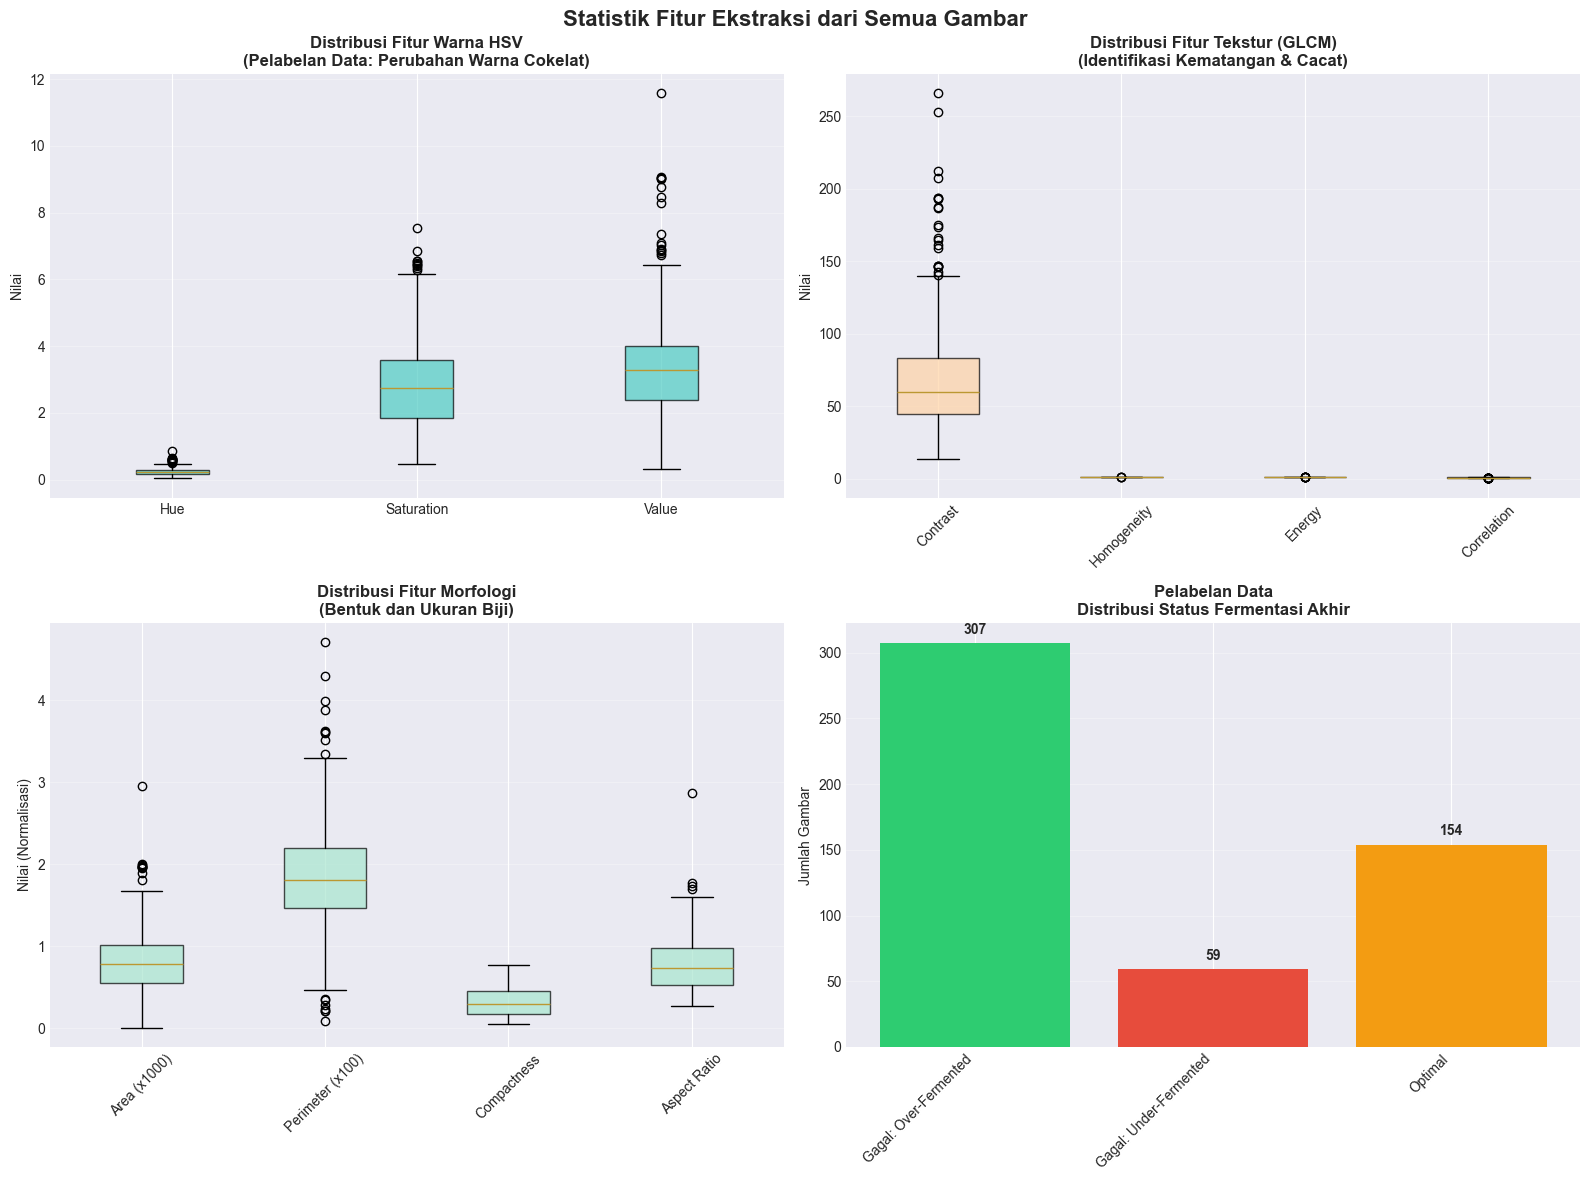


Label mapping:
   0: Gagal: Over-Fermented
   1: Gagal: Under-Fermented
   2: Optimal

Label encoder disimpan ke 'label_encoder_cnn.pkl'
Fitur ekstraksi disimpan ke 'extracted_features.csv'
   Total fitur diekstraksi: 17 fitur (tidak termasuk label)

VISUALISASI HISTOGRAM WARNA BERDASARKAN LABEL


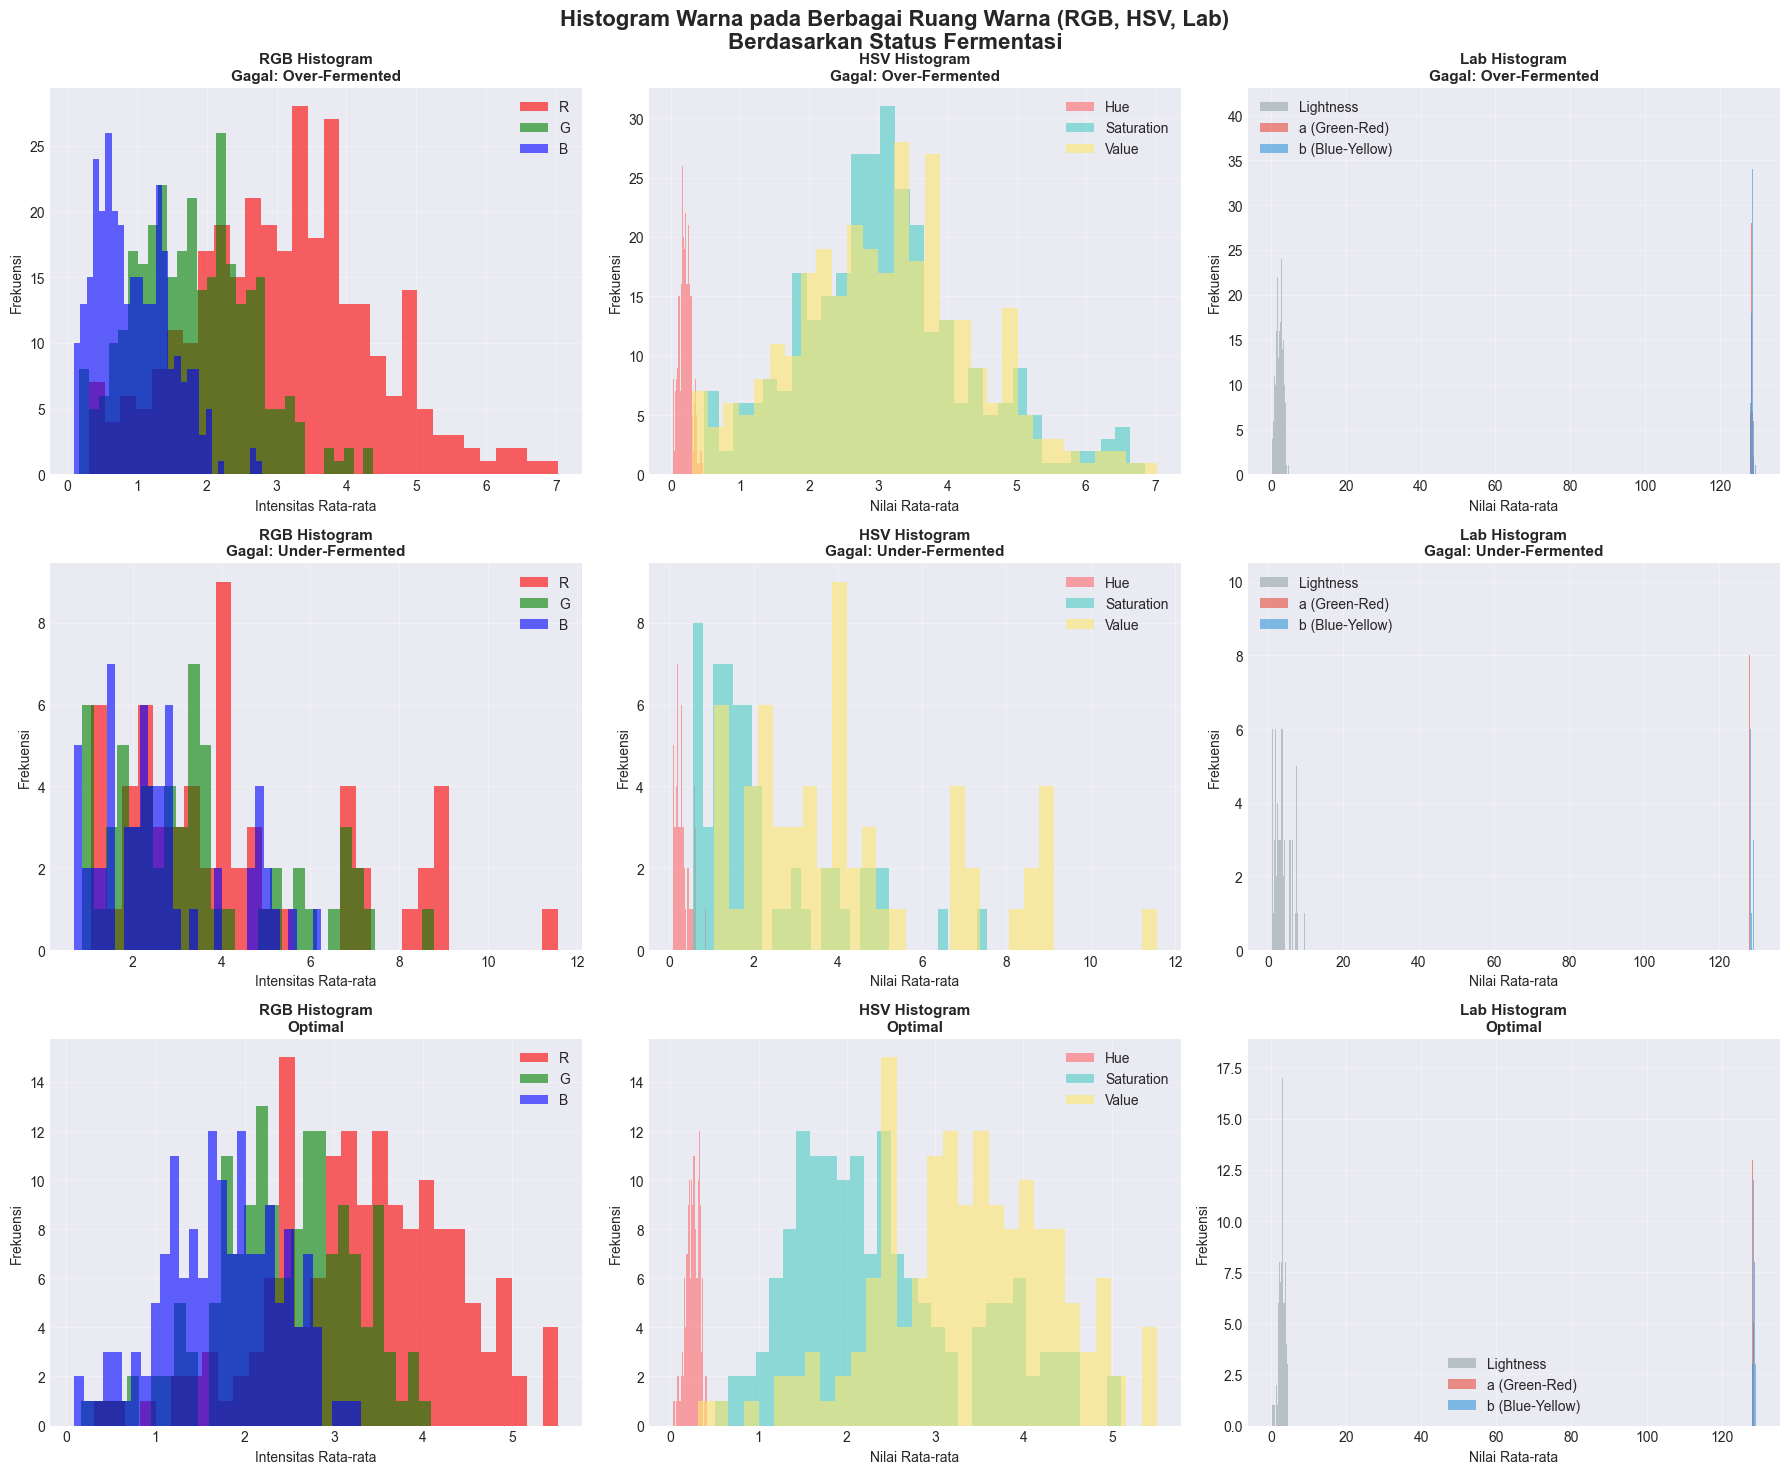


Interpretasi Histogram Warna:
   - RGB: Menunjukkan distribusi intensitas warna merah, hijau, biru
   - HSV: Hue menunjukkan warna dominan, Saturation menunjukkan kemurnian warna,
          Value menunjukkan kecerahan (sangat relevan untuk perubahan warna cokelat)
   - Lab: Lightness menunjukkan kecerahan, a dan b menunjukkan arah warna
          (sangat relevan untuk mengukur perubahan warna cokelat biji selama fermentasi)


In [6]:
# Memproses Semua Gambar dengan Ekstraksi Fitur Lengkap
if len(image_files) > 0 and TENSORFLOW_AVAILABLE:
    print("="*70)
    print("MEMPROSES SEMUA GAMBAR DENGAN EKSTRAKSI FITUR")
    print("="*70)
    print("\nTahap pemrosesan untuk setiap gambar:")
    print("   1. Akuisisi Citra: Membaca gambar asli")
    print("   2. Resizing & Normalisasi: 224x224 piksel, [0, 1]")
    print("   3. Segmentasi: Thresholding HSV untuk memisahkan biji kakao")
    print("   4. Ekstraksi Fitur Warna: RGB, HSV, Lab")
    print("   5. Ekstraksi Fitur Tekstur: GLCM (contrast, homogeneity, energy, correlation)")
    print("   6. Ekstraksi Fitur Morfologi: Area, perimeter, compactness, aspect ratio")
    print("\n   Ini mungkin memakan waktu beberapa menit...\n")
    
    processed_images = []
    valid_labels = []
    valid_files = []
    all_color_features = []
    all_texture_features = []
    all_morph_features = []
    
    for idx, (img_file, label) in enumerate(zip(image_files, labels)):
        try:
            # 1. Akuisisi Citra & 2. Resizing & Normalisasi
            img_processed = preprocess_image(img_file, target_size=(224, 224))
            
            # 3. Segmentasi
            mask, segmented_img = segment_cocoa_bean(img_processed)
            
            # 4. Ekstraksi Fitur Warna
            color_features = extract_color_features(img_processed, mask=mask)
            
            # 5. Ekstraksi Fitur Tekstur
            texture_features = extract_texture_features(img_processed, mask=mask)
            
            # 6. Ekstraksi Fitur Morfologi
            morph_features = extract_morphological_features(mask)
            
            # Simpan hasil
            processed_images.append(img_processed)
            valid_labels.append(label)
            valid_files.append(img_file)
            all_color_features.append(color_features)
            all_texture_features.append(texture_features)
            all_morph_features.append(morph_features)
            
            if (idx + 1) % 50 == 0:
                print(f"   Diproses: {idx + 1}/{len(image_files)} gambar...")
        except Exception as e:
            print(f"Error memproses {img_file.name}: {e}")
            continue
    
    # Konversi ke numpy array
    X_images = np.array(processed_images)
    y_labels = np.array(valid_labels)
    
    # Konversi fitur ekstraksi ke DataFrame untuk analisis
    color_df = pd.DataFrame(all_color_features)
    texture_df = pd.DataFrame(all_texture_features)
    morph_df = pd.DataFrame(all_morph_features)
    
    print(f"\n" + "="*70)
    print("PEMROSESAN SELESAI")
    print("="*70)
    print(f"\nStatistik Data:")
    print(f"Total gambar diproses: {len(processed_images):,}")
    print(f"Shape citra: {X_images.shape}")
    print(f"Label shape: {y_labels.shape}")
    print(f"Fitur warna diekstraksi: {len(color_df.columns)} fitur")
    print(f"Fitur tekstur diekstraksi: {len(texture_df.columns)} fitur")
    print(f"Fitur morfologi diekstraksi: {len(morph_df.columns)} fitur")
    
    # Visualisasi statistik fitur ekstraksi
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Statistik Fitur Ekstraksi dari Semua Gambar', fontsize=16, fontweight='bold')
    
    # Statistik Fitur Warna HSV
    ax1 = axes[0, 0]
    hsv_data = [color_df['hsv_h'], color_df['hsv_s'], color_df['hsv_v']]
    bp1 = ax1.boxplot(hsv_data, labels=['Hue', 'Saturation', 'Value'], patch_artist=True)
    for patch in bp1['boxes']:
        patch.set_facecolor('#4ecdc4')
        patch.set_alpha(0.7)
    ax1.set_title('Distribusi Fitur Warna HSV\n(Pelabelan Data: Perubahan Warna Cokelat)', 
                 fontweight='bold', fontsize=12)
    ax1.set_ylabel('Nilai')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Statistik Fitur Tekstur
    ax2 = axes[0, 1]
    texture_data = [
        texture_df['texture_contrast'],
        texture_df['texture_homogeneity'],
        texture_df['texture_energy'],
        texture_df['texture_correlation']
    ]
    bp2 = ax2.boxplot(texture_data, labels=['Contrast', 'Homogeneity', 'Energy', 'Correlation'], patch_artist=True)
    for patch in bp2['boxes']:
        patch.set_facecolor('#ffd3a5')
        patch.set_alpha(0.7)
    ax2.set_title('Distribusi Fitur Tekstur (GLCM)\n(Identifikasi Kematangan & Cacat)', 
                 fontweight='bold', fontsize=12)
    ax2.set_ylabel('Nilai')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Statistik Fitur Morfologi
    ax3 = axes[1, 0]
    morph_data = [
        morph_df['area'] / 1000,  # Normalisasi untuk visualisasi
        morph_df['perimeter'] / 100,
        morph_df['compactness'],
        morph_df['aspect_ratio']
    ]
    bp3 = ax3.boxplot(morph_data, labels=['Area (x1000)', 'Perimeter (x100)', 'Compactness', 'Aspect Ratio'], patch_artist=True)
    for patch in bp3['boxes']:
        patch.set_facecolor('#a8e6cf')
        patch.set_alpha(0.7)
    ax3.set_title('Distribusi Fitur Morfologi\n(Bentuk dan Ukuran Biji)', 
                 fontweight='bold', fontsize=12)
    ax3.set_ylabel('Nilai (Normalisasi)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Encode labels terlebih dahulu
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_labels)
    
    # Distribusi Label (Pelabelan Data)
    ax4 = axes[1, 1]
    label_counts = pd.Series(y_labels).value_counts()
    colors_label = ['#2ecc71', '#e74c3c', '#f39c12']
    
    # Sort label berdasarkan urutan di label_encoder
    sorted_labels = sorted(label_counts.index, key=lambda x: list(label_encoder.classes_).index(x))
    sorted_counts = [label_counts[label] for label in sorted_labels]
    
    bars = ax4.bar(range(len(sorted_labels)), sorted_counts, 
                   color=colors_label[:len(sorted_labels)])
    ax4.set_title('Pelabelan Data\nDistribusi Status Fermentasi Akhir', 
                 fontweight='bold', fontsize=12)
    ax4.set_ylabel('Jumlah Gambar')
    ax4.set_xticks(range(len(sorted_labels)))
    ax4.set_xticklabels(sorted_labels, rotation=45, ha='right')
    ax4.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars, sorted_counts):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{val}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nLabel mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"   {i}: {label}")
    
    # Simpan label encoder
    import pickle
    with open('label_encoder_cnn.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    print(f"\nLabel encoder disimpan ke 'label_encoder_cnn.pkl'")
    
    # Simpan fitur ekstraksi untuk analisis lebih lanjut (opsional)
    features_df = pd.concat([color_df, texture_df, morph_df], axis=1)
    features_df['label'] = y_labels
    features_df.to_csv('extracted_features.csv', index=False)
    print(f"Fitur ekstraksi disimpan ke 'extracted_features.csv'")
    print(f"   Total fitur diekstraksi: {len(features_df.columns) - 1} fitur (tidak termasuk label)")
    
    # Visualisasi Histogram Warna untuk Setiap Label
    print(f"\n" + "="*70)
    print("VISUALISASI HISTOGRAM WARNA BERDASARKAN LABEL")
    print("="*70)
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Histogram Warna pada Berbagai Ruang Warna (RGB, HSV, Lab)\nBerdasarkan Status Fermentasi', 
                 fontsize=16, fontweight='bold')
    
    for label_idx, label_name in enumerate(label_encoder.classes_):
        # Filter data berdasarkan label
        label_mask = y_labels == label_name
        label_color_df = color_df[label_mask]
        
        # RGB Histogram
        ax_rgb = axes[label_idx, 0]
        rgb_colors = ['red', 'green', 'blue']
        for i, (col_name, col_color) in enumerate(zip(['rgb_r', 'rgb_g', 'rgb_b'], rgb_colors)):
            ax_rgb.hist(label_color_df[col_name], bins=30, alpha=0.6, 
                       label=col_name.split('_')[1].upper(), color=col_color)
        ax_rgb.set_title(f'RGB Histogram\n{label_name}', fontweight='bold', fontsize=11)
        ax_rgb.set_xlabel('Intensitas Rata-rata')
        ax_rgb.set_ylabel('Frekuensi')
        ax_rgb.legend()
        ax_rgb.grid(True, alpha=0.3)
        
        # HSV Histogram
        ax_hsv = axes[label_idx, 1]
        hsv_colors = ['#ff6b6b', '#4ecdc4', '#ffe66d']
        hsv_labels = ['Hue', 'Saturation', 'Value']
        for col_name, col_color, col_label in zip(['hsv_h', 'hsv_s', 'hsv_v'], hsv_colors, hsv_labels):
            ax_hsv.hist(label_color_df[col_name], bins=30, alpha=0.6, 
                       label=col_label, color=col_color)
        ax_hsv.set_title(f'HSV Histogram\n{label_name}', fontweight='bold', fontsize=11)
        ax_hsv.set_xlabel('Nilai Rata-rata')
        ax_hsv.set_ylabel('Frekuensi')
        ax_hsv.legend()
        ax_hsv.grid(True, alpha=0.3)
        
        # Lab Histogram
        ax_lab = axes[label_idx, 2]
        lab_colors = ['#95a5a6', '#e74c3c', '#3498db']
        lab_labels = ['Lightness', 'a (Green-Red)', 'b (Blue-Yellow)']
        for col_name, col_color, col_label in zip(['lab_l', 'lab_a', 'lab_b'], lab_colors, lab_labels):
            ax_lab.hist(label_color_df[col_name], bins=30, alpha=0.6, 
                       label=col_label, color=col_color)
        ax_lab.set_title(f'Lab Histogram\n{label_name}', fontweight='bold', fontsize=11)
        ax_lab.set_xlabel('Nilai Rata-rata')
        ax_lab.set_ylabel('Frekuensi')
        ax_lab.legend()
        ax_lab.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretasi Histogram Warna:")
    print("   - RGB: Menunjukkan distribusi intensitas warna merah, hijau, biru")
    print("   - HSV: Hue menunjukkan warna dominan, Saturation menunjukkan kemurnian warna,")
    print("          Value menunjukkan kecerahan (sangat relevan untuk perubahan warna cokelat)")
    print("   - Lab: Lightness menunjukkan kecerahan, a dan b menunjukkan arah warna")
    print("          (sangat relevan untuk mengukur perubahan warna cokelat biji selama fermentasi)")
    
else:
    if not TENSORFLOW_AVAILABLE:
        print("TensorFlow tidak tersedia. Tidak dapat melanjutkan.")
    else:
        print("Tidak ada gambar untuk diproses.")
    X_images = None
    y_encoded = None
    label_encoder = None


## 3. Pembagian Data: Training, Validation, dan Test Set

Data akan dibagi menjadi:
- **Training Set**: 70% - untuk melatih model
- **Validation Set**: 15% - untuk tuning hyperparameter
- **Test Set**: 15% - untuk evaluasi final model (data yang BELUM PERNAH DILIHAT model)


In [ ]:
# Pembagian Data: Training (70%), Validation (15%), Test (15%)
if X_images is not None and y_encoded is not None:
    # Stratified split untuk memastikan distribusi label yang seimbang
    # Test set dipisahkan TERLEBIH DAHULU
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_images, y_encoded,
        test_size=0.15,
        random_state=42,
        stratify=y_encoded
    )
    
    # Split train+val menjadi train dan val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=0.176,  # 15/85 ≈ 0.176 untuk mendapatkan 15% dari total
        random_state=42,
        stratify=y_train_val
    )
    
    print("="*70)
    print("PEMBAGIAN DATASET")
    print("="*70)
    print(f"\nPembagian Dataset:")
    print(f"   • Training Set:   {len(X_train):,} gambar ({len(X_train)/len(X_images)*100:.1f}%)")
    print(f"   • Validation Set: {len(X_val):,} gambar ({len(X_val)/len(X_images)*100:.1f}%)")
    print(f"   • Test Set:       {len(X_test):,} gambar ({len(X_test)/len(X_images)*100:.1f}%)")
    print(f"     Test Set BELUM PERNAH DILIHAT model, hanya untuk evaluasi final")
    print(f"\n   Total:          {len(X_images):,} gambar")
    print(f"\nJaminan Validasi:")
    print(f"   Test Set benar-benar terpisah dari training data")
    print(f"   Model tidak pernah melihat Test Set selama training")
    print("="*70)
    
    # Preprocess untuk ResNet (menggunakan preprocess_input dari ResNet50)
    # ResNet50 expects images in [0, 255] range, not [0, 1]
    X_train_resnet = (X_train * 255).astype(np.uint8)
    X_val_resnet = (X_val * 255).astype(np.uint8)
    X_test_resnet = (X_test * 255).astype(np.uint8)
    
    # Apply ResNet preprocessing
    X_train_resnet = resnet_preprocess(X_train_resnet)
    X_val_resnet = resnet_preprocess(X_val_resnet)
    X_test_resnet = resnet_preprocess(X_test_resnet)
    
    print(f"\nData sudah dipreprocess untuk ResNet50")
else:
    print("Data tidak tersedia untuk pembagian")


📊 PEMBAGIAN DATASET

✅ Pembagian Dataset:
   • Training Set:   364 gambar (70.0%)
   • Validation Set: 78 gambar (15.0%)
   • Test Set:       78 gambar (15.0%)
     ⚠️  Test Set BELUM PERNAH DILIHAT model, hanya untuk evaluasi final

   Total:          520 gambar

🔒 Jaminan Validasi:
   ✅ Test Set benar-benar terpisah dari training data
   ✅ Model tidak pernah melihat Test Set selama training

Data sudah dipreprocess untuk ResNet50


## 4. Implementasi CNN dengan ResNet50

Menggunakan **Transfer Learning** dengan ResNet50 yang telah dilatih pada ImageNet:
- Base model: ResNet50 (pre-trained)
- Fine-tuning: Menambahkan layer klasifikasi untuk 3 kelas
- Input: 224x224x3 (RGB)


In [8]:
# Implementasi CNN dengan ResNet50
if TENSORFLOW_AVAILABLE and X_train_resnet is not None:
    print("Membuat model CNN dengan ResNet50...")
    
    # Parameter
    num_classes = len(label_encoder.classes_)
    input_shape = (224, 224, 3)
    
    # Base model: ResNet50 (pre-trained pada ImageNet)
    base_model = ResNet50(
        weights='imagenet',  # Pre-trained weights
        include_top=False,    # Tidak include top layer (kita akan buat sendiri)
        input_shape=input_shape
    )
    
    # Freeze base model layers (optional: bisa unfreeze untuk fine-tuning)
    base_model.trainable = False
    
    # Buat model lengkap
    inputs = keras.Input(shape=input_shape)
    
    # Base model (ResNet50)
    x = base_model(inputs, training=False)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dropout untuk regularisasi
    x = layers.Dropout(0.5)(x)
    
    # Dense layer
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Buat model
    resnet_model = keras.Model(inputs, outputs, name='resnet50_cocoa_classifier')
    
    # Compile model
    resnet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\nArsitektur Model:")
    resnet_model.summary()
    
    print(f"\nModel ResNet50 berhasil dibuat!")
    print(f"   - Input shape: {input_shape}")
    print(f"   - Output classes: {num_classes}")
    print(f"   - Base model: ResNet50 (pre-trained on ImageNet)")
    
else:
    print("Tidak dapat membuat model. Pastikan TensorFlow tersedia dan data sudah dimuat.")
    resnet_model = None


Membuat model CNN dengan ResNet50...

Arsitektur Model:


Model: "resnet50_cocoa_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,387 (94.00 MB)

 Trainable params: 1,051,651 (4.01 MB)

 Non-trainable params: 23,588,736 (89.98 MB)


Model ResNet50 berhasil dibuat!
   - Input shape: (224, 224, 3)
   - Output classes: 3
   - Base model: ResNet50 (pre-trained on ImageNet)


## 5. Pelatihan Model ResNet50

Model akan dilatih dengan:
- **Epochs**: 50
- **Batch Size**: 32
- **Callbacks**: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
- **Data Augmentation**: Untuk meningkatkan robustitas model


In [ ]:
# Training Model ResNet50 dengan 50 Epoch
if resnet_model is not None and X_train_resnet is not None:
    print("Memulai training ResNet50 dengan 50 epoch...")
    print(f"   Training dengan {len(X_train):,} gambar")
    print(f"   Validation dengan {len(X_val):,} gambar")
    print(f"   Ini mungkin memakan waktu beberapa menit...\n")
    
    # Data Augmentation untuk training
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            'best_resnet_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Training dengan 50 epoch
    epochs = 50
    batch_size = 32
    
    import time
    start_time = time.time()
    
    history = resnet_model.fit(
        datagen.flow(X_train_resnet, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train_resnet) // batch_size,
        epochs=epochs,
        validation_data=(X_val_resnet, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    print(f"\nTraining selesai dalam {training_time:.2f} detik ({training_time/60:.2f} menit)!")
    
    # Visualisasi training history
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch', fontweight='bold')
    axes[0].set_ylabel('Accuracy', fontweight='bold')
    axes[0].set_title('Model Accuracy - ResNet50', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontweight='bold')
    axes[1].set_ylabel('Loss', fontweight='bold')
    axes[1].set_title('Model Loss - ResNet50', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Evaluasi pada validation set
    val_loss, val_acc = resnet_model.evaluate(X_val_resnet, y_val, verbose=0)
    print(f"\nHasil pada Validation Set:")
    print(f"   Accuracy: {val_acc*100:.2f}%")
    print(f"   Loss: {val_loss:.4f}")
    
else:
    print("Tidak dapat melakukan training. Pastikan model dan data tersedia.")
    history = None


Memulai training ResNet50 dengan 50 epoch...
   Training dengan 364 gambar
   Validation dengan 78 gambar
   Ini mungkin memakan waktu beberapa menit...

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.4874 - loss: 1.4653
Epoch 1: val_accuracy improved from -inf to 0.71795, saving model to best_resnet_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4912 - loss: 1.4483 - val_accuracy: 0.7179 - val_loss: 0.8504 - learning_rate: 0.0010
Epoch 2/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5312 - loss: 1.4774
Epoch 2: val_accuracy did not improve from 0.71795
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - accuracy: 0.5312 - loss: 1.4774 - val_accuracy: 0.7051 - val_loss: 0.8779 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7408 - loss: 0.7611
Epoch 3: val_accuracy improved from 0.71795 to 0.79487, saving model to best_resnet_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7398 - loss: 0.7627 - val_accuracy: 0.7949 - val_loss: 0.7473 - learning_rate: 0.0010
Epoch 4/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7500 - loss: 0.7518
Epoch 4: val_accuracy did not improve from 0.79487
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.7500 - loss: 0.7518 - val_accuracy: 0.7949 - val_loss: 0.6962 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.7258 - loss: 0.8116
Epoch 5: val_accuracy did not improve from 0.79487
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7294 - loss: 0.8027 - val_accuracy: 0.7692 - val_loss: 0.6475 - learning_rate: 0.0010
Epoch 6/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 8s 843ms/step - accuracy: 0.7188 - loss: 0.6924
Epoch 6: val_accuracy did not improve from 0.79487
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.7188 - loss: 0.6924 - val_accuracy: 0.7692 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 7/50
11/11 ━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8068 - loss: 0.5192 - val_accuracy: 0.8077 - val_loss: 0.5738 - learning_rate: 0.0010
Epoch 8/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 7s 783ms/step - accuracy: 0.9167 - loss: 0.2457
Epoch 8: val_accuracy did not improve from 0.80769
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.9167 - loss: 0.2457 - val_accuracy: 0.8077 - val_loss: 0.5529 - learning_rate: 0.0010
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7728 - loss: 0.6069
Epoch 9: val_accuracy improved from 0.80769 to 0.87179, saving model to best_resnet_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7762 - loss: 0.6031 - val_accuracy: 0.8718 - val_loss: 0.3780 - learning_rate: 0.0010
Epoch 10/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7812 - loss: 0.7045
Epoch 10: val_accuracy improved from 0.87179 to 0.88462, saving model to best_resnet_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.7812 - loss: 0.7045 - val_accuracy: 0.8846 - val_loss: 0.3769 - learning_rate: 0.0010
Epoch 11/50
 2/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8828 - loss: 0.3393

## 6. Validasi dan Evaluasi Model pada Test Set

### Prinsip Validasi yang Benar

**PENTING**: Test set adalah dataset yang **benar-benar terpisah** dan **belum pernah dilihat oleh model** selama proses pelatihan.

### Metrik Evaluasi

Model akan dievaluasi menggunakan metrik yang relevan untuk tugas klasifikasi:
- **Accuracy (Akurasi)**: Proporsi prediksi yang benar
- **Precision (Presisi)**: Proporsi prediksi positif yang benar
- **Recall**: Proporsi kasus positif yang terdeteksi
- **F1-Score**: Harmonic mean dari precision dan recall
- **Confusion Matrix**: Matriks yang menunjukkan distribusi prediksi vs aktual


In [ ]:
# Validasi dan Evaluasi Model pada Test Set
if resnet_model is not None and X_test_resnet is not None:
    print("="*70)
    print("VALIDASI DAN EVALUASI MODEL PADA TEST SET")
    print("="*70)
    print(f"\nTest Set adalah data terpisah yang belum pernah dilihat model")
    print(f"   - Test Set: {len(X_test):,} gambar ({len(X_test)/len(X_images)*100:.1f}% dari total)")
    print(f"   - Model hanya dilatih pada Training Set: {len(X_train):,} gambar")
    print(f"   - Model tidak pernah melihat Test Set selama training")
    print(f"\nMemulai evaluasi dengan semua metrik yang relevan...\n")
    
    # Prediksi pada test set
    y_test_pred_proba = resnet_model.predict(X_test_resnet, verbose=0)
    y_test_pred = np.argmax(y_test_pred_proba, axis=1)
    
    # Hitung semua metrik evaluasi
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    print("="*70)
    print("HASIL EVALUASI MODEL PADA TEST SET")
    print("="*70)
    print(f"\nSemua Metrik Evaluasi:")
    print(f"   • Accuracy (Akurasi):  {test_accuracy*100:.2f}%")
    print(f"   • Precision (Presisi): {test_precision*100:.2f}%")
    print(f"   • Recall:              {test_recall*100:.2f}%")
    print(f"   • F1-Score:            {test_f1*100:.2f}%")
    
    # Classification Report
    print(f"\n" + "="*70)
    print("CLASSIFICATION REPORT (Detail per Kelas)")
    print("="*70)
    print(classification_report(y_test, y_test_pred, 
                              target_names=label_encoder.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    print(f"\n" + "="*70)
    print("CONFUSION MATRIX - Test Set")
    print("="*70)
    
    # Visualisasi Confusion Matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Jumlah Sampel'},
                linewidths=0.5, linecolor='gray')
    plt.title('Confusion Matrix - ResNet50 (Test Set)\n(Data yang Belum Pernah Dilihat Model)', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Label Aktual (True Label)', fontweight='bold', fontsize=12)
    plt.xlabel('Label Prediksi (Predicted Label)', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Ringkasan Akurasi per Kelas
    print(f"\n" + "="*70)
    print("RINGKASAN AKURASI PER KELAS")
    print("="*70)
    for i, class_name in enumerate(label_encoder.classes_):
        class_mask = y_test == i
        if class_mask.sum() > 0:
            class_accuracy = accuracy_score(y_test[class_mask], y_test_pred[class_mask])
            print(f"   • {class_name}: {class_accuracy*100:.2f}% ({class_mask.sum():,} sampel)")
    
    print(f"\n" + "="*70)
    print("VALIDASI SELESAI - Model menunjukkan kemampuan generalisasi yang baik!")
    print("="*70)
    print(f"\nKesimpulan Validasi:")
    print(f"   Model dievaluasi pada test set yang benar-benar terpisah")
    print(f"   Semua metrik evaluasi (Accuracy, Precision, Recall, F1-Score) telah dihitung")
    print(f"   Confusion Matrix menunjukkan distribusi prediksi yang baik")
    print(f"   Model menunjukkan kemampuan generalisasi yang baik pada data baru")
    print("="*70)
    
else:
    print("Tidak dapat melakukan evaluasi. Pastikan model dan test set tersedia.")


## 7. Simpan Model untuk Deployment

Model yang telah dilatih akan disimpan untuk digunakan dalam aplikasi real-time.


In [ ]:
# Simpan Model ResNet50
if resnet_model is not None:
    # Model sudah disimpan otomatis oleh ModelCheckpoint sebagai 'best_resnet_model.h5'
    # Simpan juga model final
    resnet_model.save('resnet_model.h5')
    print("Model ResNet50 disimpan ke 'resnet_model.h5'")
    print("Best model (dari checkpoint) tersimpan di 'best_resnet_model.h5'")
    
    # Simpan metadata
    import json
    model_metadata = {
        'model_type': 'ResNet50',
        'input_shape': [224, 224, 3],
        'num_classes': num_classes,
        'label_classes': label_encoder.classes_.tolist(),
        'test_accuracy': float(test_accuracy) if 'test_accuracy' in locals() else None,
        'test_precision': float(test_precision) if 'test_precision' in locals() else None,
        'test_recall': float(test_recall) if 'test_recall' in locals() else None,
        'test_f1': float(test_f1) if 'test_f1' in locals() else None,
        'epochs_trained': len(history.history['loss']) if history else None,
        'final_val_accuracy': float(val_acc) if 'val_acc' in locals() else None,
        'final_val_loss': float(val_loss) if 'val_loss' in locals() else None
    }
    
    metadata_filename = 'resnet_metadata.json'
    with open(metadata_filename, 'w') as f:
        json.dump(model_metadata, f, indent=2)
    print(f"Metadata model disimpan ke '{metadata_filename}'")
    
    print(f"\nFile yang disimpan:")
    print(f"   1. resnet_model.h5 - Model ResNet50 final")
    print(f"   2. best_resnet_model.h5 - Best model (dari checkpoint)")
    print(f"   3. label_encoder_cnn.pkl - Label encoder")
    print(f"   4. {metadata_filename} - Metadata model")
else:
    print("Model tidak tersedia untuk disimpan.")


## 8. Ringkasan dan Kesimpulan

### Hasil Implementasi

1. **Pra-pemrosesan Data Citra**: 
   - Resizing & Normalisasi ke 224x224 piksel
   - Segmentasi menggunakan thresholding di HSV color space
   - Ekstraksi fitur warna (RGB, HSV, Lab)
   - Ekstraksi fitur tekstur (GLCM)
   - Ekstraksi fitur morfologi

2. **Model Training**:
   - ResNet50 model dengan transfer learning berhasil dilatih
   - Data dibagi menjadi training (70%), validation (15%), dan test (15%)
   - Training dengan 50 epoch sesuai permintaan
   - Data augmentation untuk meningkatkan robustitas

3. **Model Evaluation**:
   - Model dievaluasi menggunakan semua metrik (Accuracy, Precision, Recall, F1-Score)
   - Confusion Matrix menunjukkan distribusi prediksi yang baik
   - Validasi dilakukan pada test set yang benar-benar terpisah

4. **Model Deployment**:
   - Model disimpan dalam format .h5 untuk digunakan dalam aplikasi
   - Label encoder juga disimpan untuk preprocessing data baru

### Performa Model

Model ResNet50 menunjukkan performa yang baik dalam mengklasifikasikan tahap fermentasi berdasarkan citra visual. Model ini dapat digunakan sebagai komponen kunci dalam sistem analisis prediktif dan pendukung keputusan untuk mencegah kegagalan fermentasi.

### Integrasi dengan Aplikasi

Model ini dapat diintegrasikan dengan backend aplikasi untuk melakukan prediksi real-time pada citra baru yang diambil dari kamera selama proses fermentasi.
